In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from geopy.distance import geodesic

india_data = gpd.read_file('C:/Users/lakshya.vashisth/Documents/Assignments/AI/Map_data/india_taluk.geojson')
india_data.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,NL_NAME_3,VARNAME_3,TYPE_3,ENGTYPE_3,geometry
0,105,IND,India,7,Chhattisgarh,110,Kawardha,334,Kawardha,None,None,Taluk,Taluk,"POLYGON ((81.19419 22.46208, 81.19308 22.45114..."
1,105,IND,India,7,Chhattisgarh,110,Kawardha,335,Pandaria,None,None,Taluk,Taluk,"POLYGON ((81.47986 22.49331, 81.48182 22.48764..."
2,105,IND,India,7,Chhattisgarh,111,Korba,336,Katghora,None,None,Taluk,Taluk,"POLYGON ((82.56844 22.96502, 82.56003 22.96093..."
3,105,IND,India,7,Chhattisgarh,111,Korba,337,Korba,None,None,Taluk,Taluk,"POLYGON ((82.82744 22.74267, 82.84205 22.74336..."
4,105,IND,India,7,Chhattisgarh,112,Koriya,338,Baikunthpur,None,None,Taluk,Taluk,"POLYGON ((82.49175 23.78571, 82.49255 23.77529..."


In [2]:
state_filter = ['Punjab', 'Haryana', 'Chandigarh']
filtered_df = india_data[india_data["NAME_1"].isin(state_filter)]
map = gpd.GeoDataFrame(filtered_df)
map["centroid"] = map.geometry.centroid
map.head()

C:\Users\lakshya.vashisth\AppData\Local\Temp\ipykernel_25380\3791458827.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map["centroid"] = map.geometry.centroid


,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,NL_NAME_3,VARNAME_3,TYPE_3,ENGTYPE_3,geometry,centroid
398,105,IND,India,6,Chandigarh,101,Chandigarh,305,Chandigarh,None,None,Taluk,Taluk,"POLYGON ((76.81981 30.68583, 76.81051 30.68495...",POINT (76.76828 30.73384)
643,105,IND,India,13,Haryana,149,Ambala,598,Ambala,None,None,Taluk,Taluk,"POLYGON ((77.17542 30.33329, 77.17043 30.32811...",POINT (76.87989 30.28223)
644,105,IND,India,13,Haryana,149,Ambala,599,Narayangarh,None,None,Taluk,Taluk,"POLYGON ((77.12379 30.57269, 77.12059 30.57118...",POINT (77.07832 30.45791)
645,105,IND,India,13,Haryana,150,Bhiwani,600,Bawani Khera,None,None,Taluk,Taluk,"POLYGON ((76.22315 28.99121, 76.21038 28.97851...",POINT (76.04127 28.96255)
646,105,IND,India,13,Haryana,150,Bhiwani,601,Bhiwani,None,None,Taluk,Taluk,"POLYGON ((76.23032 28.91567, 76.23981 28.91132...",POINT (76.00908 28.77797)


In [3]:
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()

# Used Spatial Join to Find Neighbors
neighbors = gpd.sjoin(map, map, how='inner', predicate='touches')

map_indexed = map.set_index('ID_3')

# Iterate Through Unique Pairs of Neighbors
for node1, node2 in zip(neighbors['ID_3_left'], neighbors['ID_3_right']):

    if node1 != node2 and not G.has_edge(node1, node2):
        centroid1 = map_indexed.at[node1, 'centroid']
        centroid2 = map_indexed.at[node2, 'centroid']
        coord1 = (centroid1.y, centroid1.x)
        coord2 = (centroid2.y, centroid2.x)
        distance = geodesic(coord1, coord2).km

        G.add_edge(map_indexed.at[node1, 'NAME_3'], map_indexed.at[node2, 'NAME_3'], weight=round(2 * distance, 2), distance=distance)

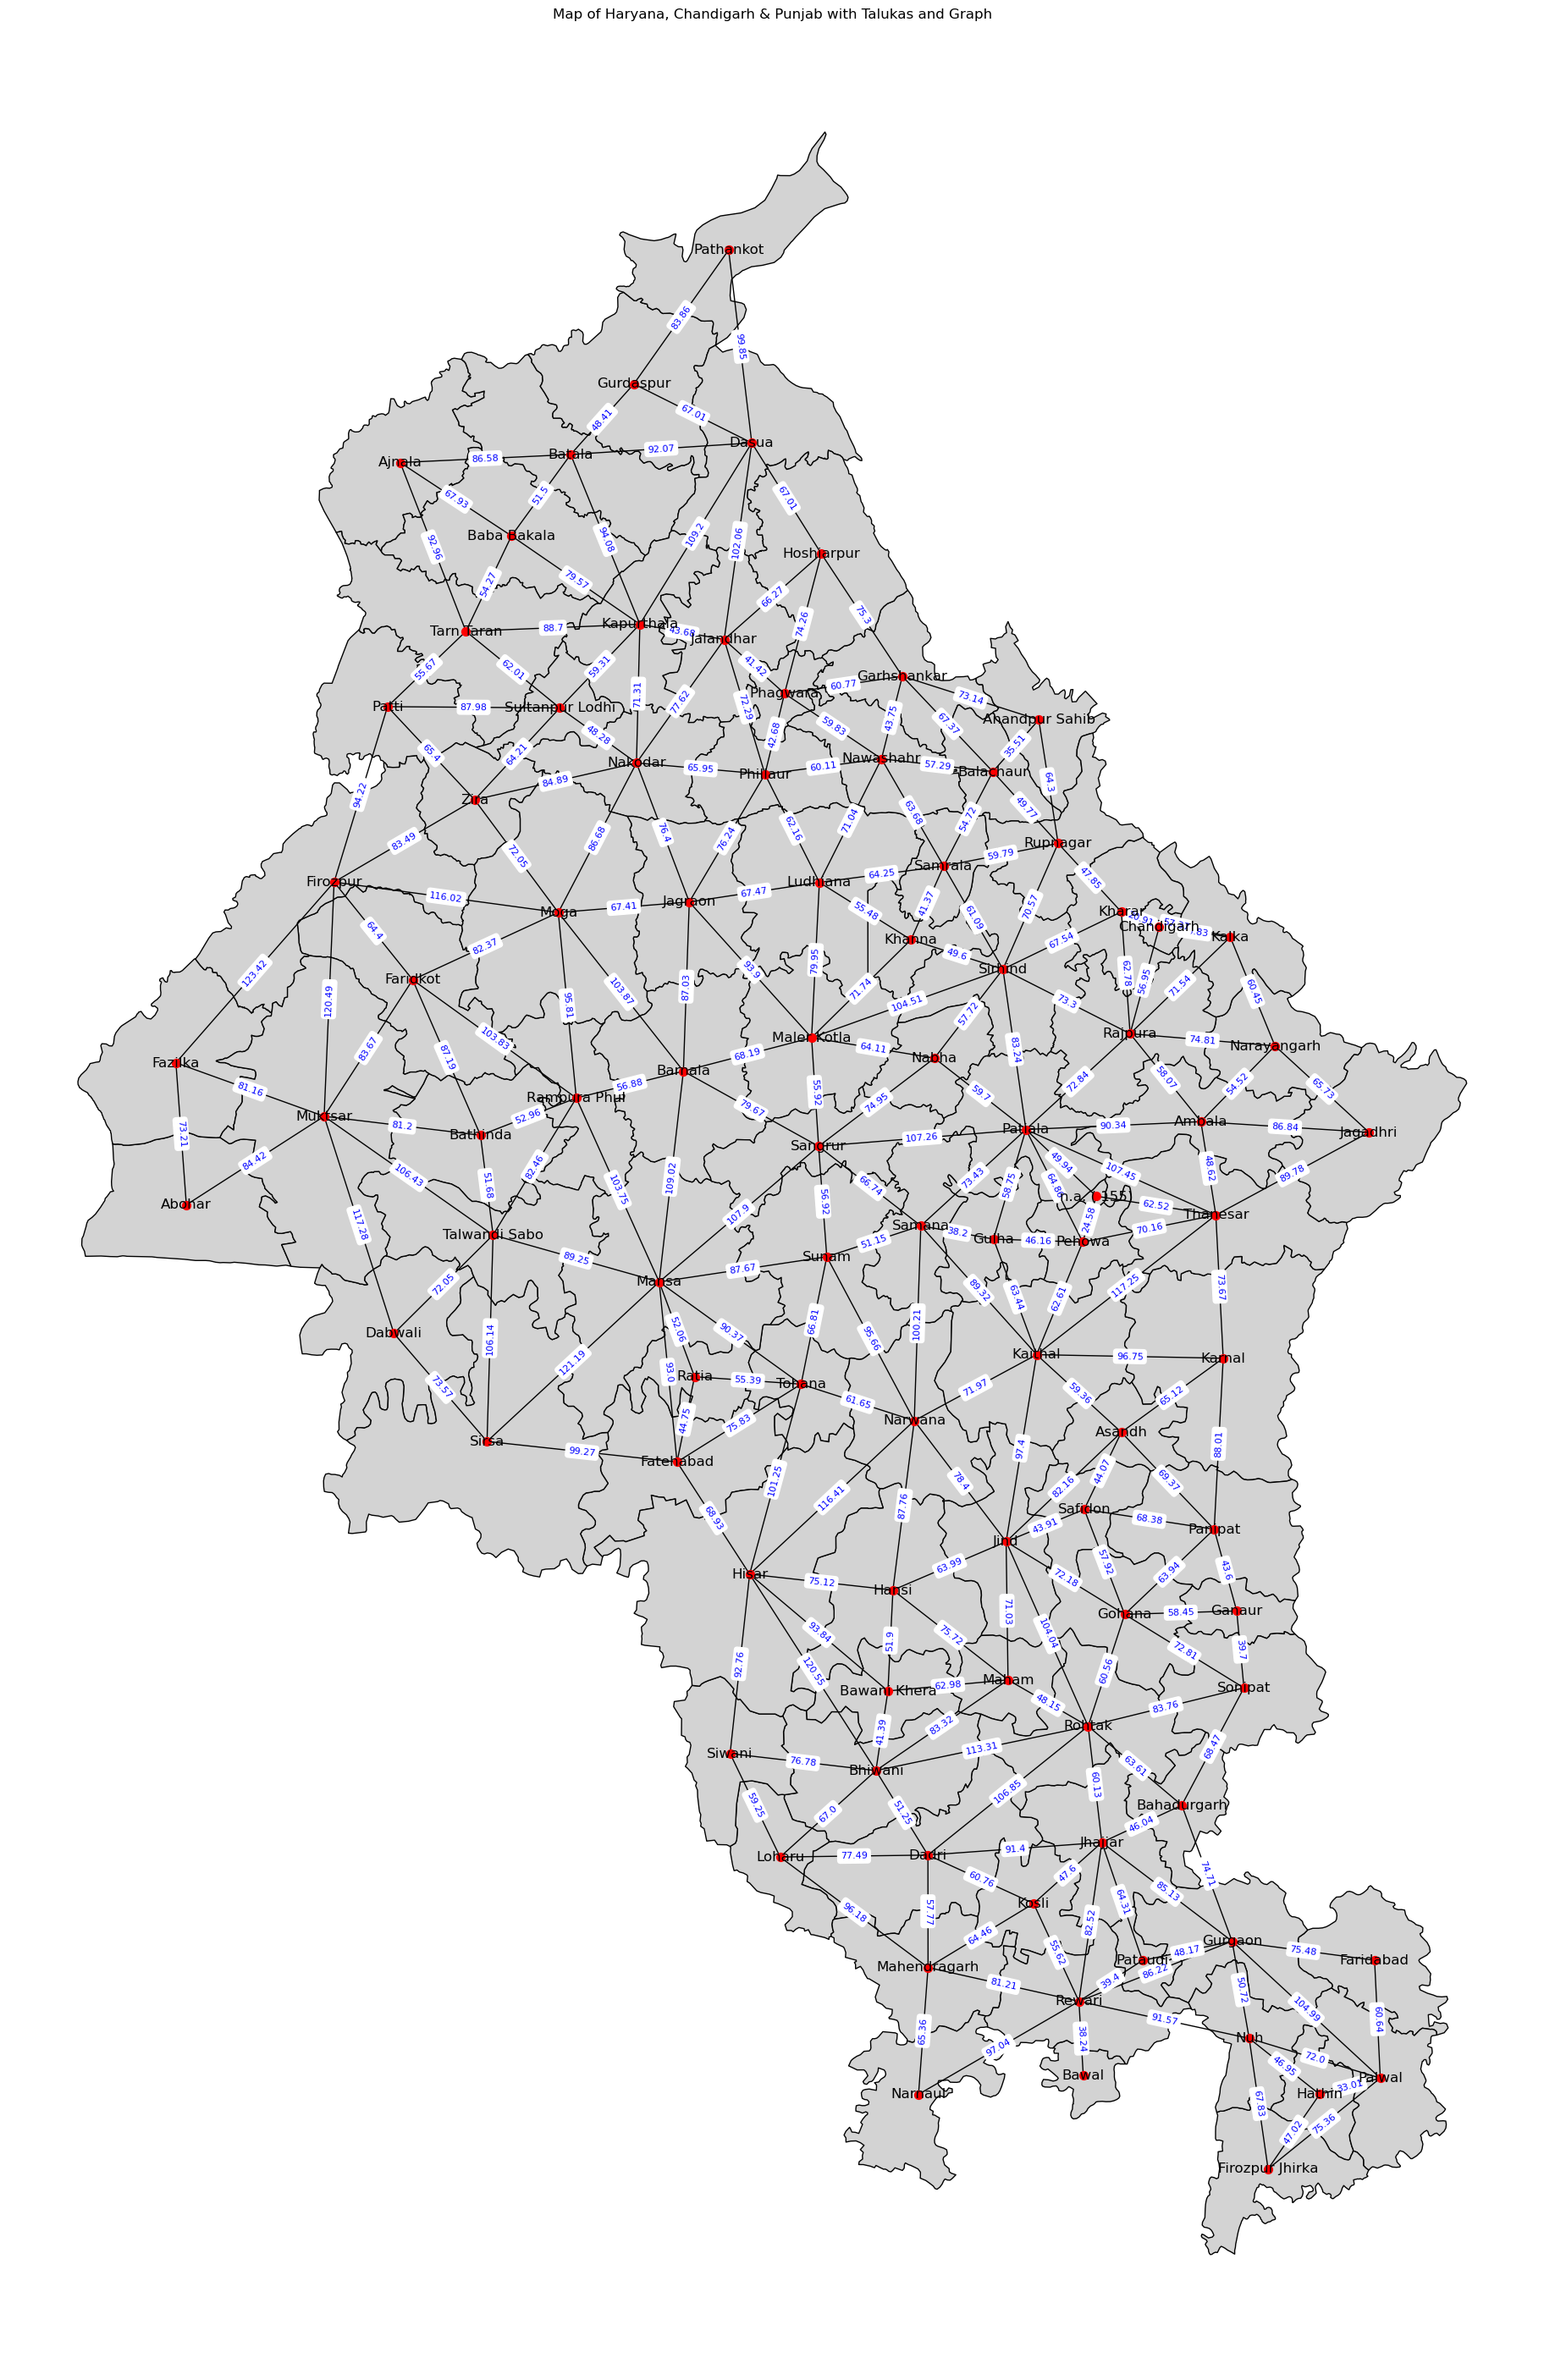

In [4]:
# Plot the map
fig, ax = plt.subplots(figsize=(28, 36))
map.plot(ax=ax, color='lightgray', edgecolor='black')

# Get node positions for plotting
map_indexed = map.set_index('NAME_3')
pos = {node: (map_indexed.loc[node]['centroid'].x, map_indexed.loc[node]['centroid'].y)
       for node in G.nodes}

labels = {node: node for node in G.nodes}

# Draw the graph with edge weights as labels
nx.draw(G, pos, ax=ax, node_size=50, node_color='red', with_labels=False)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=8)

nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_color='black')

ax.set_title("Map of Haryana, Chandigarh & Punjab with Talukas and Graph")
plt.show()

In [5]:
# Generate heuristics of the nodes
from prettytable import PrettyTable
from geopy.distance import geodesic


heuristic_sld_fwd={}
heuristic_sld_back={}
# take start and end node
start = "Sirsa"
goal = "Ludhiana"


row_goal = map[map['NAME_3'] == goal].iloc[0]
row_start = map[map['NAME_3'] == start].iloc[0]

edge_labels = {}
for i, row1 in map.iterrows():
    for j, row2 in map.iterrows():
        if i != j and row1.geometry.touches(row2.geometry):
            coord1 = (row1.centroid.y, row1.centroid.x)
            coord2 = (row2.centroid.y, row2.centroid.x)
            distance = geodesic(coord1, coord2).km
            G.add_edge(i, j, weight=round(distance, 2))
            edge_labels[(i, j)] = f"{round(distance, 2)}"


for i, row in map.iterrows():
  coord1 = (row.centroid.y, row.centroid.x)
  coord2 = (row_goal.centroid.y, row_goal.centroid.x)
  heuristic_sld_fwd[row.NAME_3] = round(geodesic(coord1, coord2).km, 2)

for i, row in map.iterrows():
  coord1 = (row.centroid.y, row.centroid.x)
  coord2 = (row_start.centroid.y, row_start.centroid.x)
  heuristic_sld_back[row.NAME_3] = round(geodesic(coord1, coord2).km, 2)

print("Heuristic Table with Start Node as",start, "and Goal Node as",goal)
t = PrettyTable(['Taluka', 'Cost'])
for key, value in heuristic_sld_fwd.items():
  t.add_row([key, value])
print(t)

print("\n Heuristic Table with Start Node as",goal, "and Goal Node as",start)
t1 = PrettyTable(['Taluka', 'Cost'])
for key, value in heuristic_sld_back.items():
  t1.add_row([key, value])
print(t1)

Heuristic Table with Start Node as Sirsa and Goal Node as Ludhiana
+-----------------+--------+
|      Taluka     |  Cost  |
+-----------------+--------+
|    Chandigarh   | 87.92  |
|      Ambala     | 115.76 |
|   Narayangarh   | 124.33 |
|   Bawani Khera  | 208.53 |
|     Bhiwani     | 228.7  |
|      Dadri      | 251.52 |
|      Loharu     | 250.65 |
|      Siwani     | 225.06 |
|    Faridabad    | 312.2  |
|      Hathin     | 337.46 |
|      Palwal     | 340.06 |
|    Fatehabad    | 153.41 |
|      Ratia      | 131.05 |
|      Tohana     | 129.03 |
| Firozpur Jhirka | 350.57 |
|     Gurgaon     | 292.39 |
|       Nuh       | 317.32 |
|     Pataudi     | 289.44 |
|      Hansi      | 182.85 |
|      Hisar      | 178.68 |
|   Bahadurgarh   | 255.03 |
|     Jhajjar     | 257.32 |
|      Kosli      | 268.2  |
|       Jind      | 176.15 |
|     Narwana     | 140.48 |
|     Safidon     | 175.04 |
|      Gulha      | 102.05 |
|     Kaithal     | 133.66 |
|      Asandh     | 161.36 |
|    

In [6]:
import heapq

class BidirectionalGreedySearch:
  def __init__(self):
    self.frontier_start = []
    self.frontier_goal = []
    self.explored_start = []
    self.explored_goal = []
    self.fwd_cost = 0
    self.back_cost = 0

    self.children_present = []


  def bidirectional_greedy_best_first_search(self, graph, start, goal, heuristic_start, heuristic_goal):
    heapq.heappush(self.frontier_start, (heuristic_start[start], start))
    heapq.heappush(self.frontier_goal, (heuristic_goal[goal], goal))

    while self.frontier_start and self.frontier_goal:
      self.fwd_greedy_best_first_search(graph, start, heuristic_start)
      self.back_greedy_best_first_search(graph, goal, heuristic_goal)

      if self.explored_start[-1] == self.explored_goal[-1]:
        return self.explored_start, self.explored_goal, self.fwd_cost + self.back_cost, self.children_present

  def fwd_greedy_best_first_search(self, graph, start, heuristic_start):
      fwd_cost, current_start = heapq.heappop(self.frontier_start)
      self.explored_start.append(current_start)
      self.fwd_cost+=fwd_cost
      for neighbor in graph[current_start]:
        if neighbor not in self.explored_start:
          self.children_present.append((heuristic_start[neighbor], neighbor ,current_start))
          heapq.heappush(self.frontier_start, (heuristic_start[neighbor], neighbor))


  def back_greedy_best_first_search(self, graph, goal, heuristic_goal):
      back_cost, current_goal = heapq.heappop(self.frontier_goal)
      self.explored_goal.append(current_goal)
      self.back_cost+=back_cost
      for neighbor in graph[current_goal]:
          if neighbor not in self.explored_goal:
            self.children_present.append((heuristic_goal[neighbor], neighbor ,current_goal))
            heapq.heappush(self.frontier_goal, (heuristic_goal[neighbor], neighbor))


fwd_path, back_path, total_cost, children = BidirectionalGreedySearch().bidirectional_greedy_best_first_search(G, start, goal, heuristic_sld_fwd, heuristic_sld_back)
print("Forward Path: ", fwd_path)
print("Backward Path: ", back_path)
print("Meetup point: ", back_path[-1])
print("Total Distance in km: ", total_cost)

Forward Path:  ['Sirsa', 'Mansa', 'Barnala']
Backward Path:  ['Ludhiana', 'Maler Kotla', 'Barnala']
Meetup point:  Barnala
Total Distance in km:  746.3300000000002


In [7]:
#Q2
import heapq
import numpy as np

class BidirectionalGBFSRoadData:
  def __init__(self):
    self.frontier_forward = []
    self.frontier_backward = []
    self.explored_forward = []
    self.explored_backward = []
    self.cost_forward = 0
    self.cost_backward = 0

    self.children_present = []


  def bidirectional_gbfs(self, G, location1, location2, heuristic_fwd, heuristic_back):
    heapq.heappush(self.frontier_forward, (heuristic_fwd[location1], location1))
    heapq.heappush(self.frontier_backward, (heuristic_back[location2], location2))

    while self.frontier_forward and self.frontier_backward:
      self.forward_gbfs(G, location1, heuristic_fwd)
      self.backward_gbfs(G, location2, heuristic_back)

      if self.explored_forward[-1] == self.explored_backward[-1]:
        return self.explored_forward, self.explored_backward, self.cost_forward + self.cost_backward, self.children_present

  def forward_gbfs(self, G, start, heuristic_start):
      fwd_cost, current_start = heapq.heappop(self.frontier_forward)
      if current_start not in self.explored_forward:
        self.explored_forward.append(current_start)
        self.cost_forward+=fwd_cost
        for child in G[current_start]:
          if child not in self.explored_forward:
            cost = np.random.randint(700, 750)
            if heuristic_start.get(child):
              cost = heuristic_start[child]
            heapq.heappush(self.frontier_forward, (cost, child))
            self.children_present.append((cost, child ,current_start))
            heapq.heappush(self.frontier_forward, (cost, child))


  def backward_gbfs(self, G, goal, heuristic_goal):
      back_cost, current_goal = heapq.heappop(self.frontier_backward)
      if current_goal not in self.explored_backward:
        self.explored_backward.append(current_goal)
        self.cost_backward+=back_cost
        for child in G[current_goal]:
            if child not in self.explored_backward:
              cost = np.random.randint(700, 750)
            if heuristic_goal.get(child):
              cost = heuristic_goal[child]
              self.children_present.append((cost, child, current_goal))
              heapq.heappush(self.frontier_backward, (cost, child))

In [8]:
# GBFS with Road distance as heuristics
 
road_heuristics_backward = {
    "Sirsa": 0.0,
    "Ludhiana": 206.1,
    "Maler Kotla": 162.2,
    "Sangrur": 128.2,
    "Barnala": 117.0,
    "Mansa": 68.7,
    "Jagraon": 172.7,
    "Phillaur": 206.7,
    "Samrala": 215.2,
    "Khanna": 203.9,
    "Nabha": 157.8,
    "Sunam": 113.0,
    "Dabwali": 56.1,
    "Fatehabad": 40.9,
    "Ratia": 62.3,
    "Talwandi Sabo": 63.3,
    "Moga": 182.1,
    "Bhatinda": 97.6,
    "Rampura Phul": 99.8
}

road_heuristics_forward = {
    "Sirsa": 206.1,
    "Ludhiana": 0.0,
    "Maler Kotla": 46.1,
    "Sangrur": 79.7,
    "Barnala": 76.7,
    "Mansa": 126.3,
    "Jagraon": 41.9,
    "Phillaur": 16.7,
    "Samrala": 36.9,
    "Khanna": 41.7,
    "Nabha": 157.8,
    "Sunam": 76.7,
    "Dabwali": 184.8,
    "Fatehabad": 182.2,
    "Ratia": 166.6,
    "Talwandi Sabo": 154.8,
    "Moga": 69.7,
    "Bhatinda": 142.9,
    "Rampura Phul": 113.2
}

fwd_path, back_path, total_cost, children = BidirectionalGBFSRoadData().bidirectional_gbfs(G, start, goal, road_heuristics_forward, road_heuristics_backward)
print("Forward Path: ", fwd_path)
print("Backward Path: ", back_path)
print("Meetup point: ", back_path[-1])
print("Total Distance in km: ", total_cost)

Forward Path:  ['Sirsa', 'Mansa', 'Barnala']
Backward Path:  ['Ludhiana', 'Maler Kotla', 'Barnala']
Meetup point:  Barnala
Total Distance in km:  894.3999999999999


In [ ]:
import heapq

def bidirectional_astar(graph, start, goal, heuristic_fwd, heuristic_bwd):
    # Priority queues for forward and backward searches
    frontier_fwd = []
    frontier_bwd = []

    # Transition costs (g(n)) for forward and backward searches
    transition_cost_fwd = {start: 0}
    transition_cost_bwd = {goal: 0}

    # f(n) values (g(n) + h(n)) for forward and backward searches
    f_start = {start: heuristic_fwd[start]}
    f_goal = {goal: heuristic_bwd[goal]}

    # Visited nodes for forward and backward searches
    visited_start = {}
    visited_goal = {}

    fw_cost = 0
    bw_cost = 0

    # Push the start and goal nodes into their respective priority queues
    heapq.heappush(frontier_fwd, (f_start[start], start))
    heapq.heappush(frontier_bwd, (f_goal[goal], goal))

    meet_node = None  # Node where the two searches meet

    while frontier_fwd and frontier_bwd:
        # Forward search step
        if frontier_fwd:
            cost, current_start = heapq.heappop(frontier_fwd)
            if visited_goal and current_start == visited_goal[-1]:  # Check if the node is visited by backward search
                meet_node = current_start
                break
            visited_start.append(current_start)
            for neighbor in graph[current_start]:
                edge_cost = graph[current_start][neighbor]['weight']
                new_cost = transition_cost_fwd[current_start] + edge_cost

                if neighbor not in transition_cost_fwd or new_cost < transition_cost_fwd[neighbor]:
                    transition_cost_fwd[neighbor] = new_cost
                    f_start[neighbor] = new_cost + heuristic_fwd[neighbor]
                    heapq.heappush(frontier_fwd, (f_start[neighbor], neighbor))

        # Backward search step
        if frontier_bwd:
            cost, current_goal = heapq.heappop(frontier_bwd)
            if visited_start and current_start == visited_start[-1]:
                meet_node = current_goal
                break
            visited_goal.append(current_goal)
            for neighbor in graph[current_goal]:
                edge_cost = graph[current_goal][neighbor]['weight']
                new_cost = transition_cost_bwd[current_goal] + edge_cost

                if neighbor not in transition_cost_bwd or new_cost < transition_cost_bwd[neighbor]:
                    transition_cost_bwd[neighbor] = new_cost
                    f_goal[neighbor] = new_cost + heuristic_bwd[neighbor]
                    heapq.heappush(frontier_bwd, (f_goal[neighbor], neighbor))

    if meet_node is None:
        return None

    return meet_node, reconstruct_path(visited_start, visited_goal, meet_node)



def reconstruct_path(visited_start, visited_goal, meet_node):
    # Reconstruct the path from start to meet_node using forward search
    path_start = []
    current = meet_node
    while current is not None :
        path_start.append(current)
        current = visited_start

    # Reconstruct the path from goal to meet_node using backward search
    path_goal = []
    current = meet_node
    while current is not None:
        path_goal.append(current)
        current = visited_goal.get(current)

    return path_start[::-1], path_goal[1:]



meet, fwd_path, back_path = bidirectional_astar(G, start, goal, heuristic_sld_fwd, heuristic_sld_back)
print(f"Forward Path starting from {start} towards {goal}: ", fwd_path)
print(f"Backward Path from {goal} towards {start}: ", back_path)
print("Meetup taluka: ", back_path[-1])